Jelle, Feburary 2016

This tutorial describes how to use the basic functionality of the `hax` analysis library from python.

# Table of Contents
 <p><div class="lev1"><a href="#Selecting-datasets"><span class="toc-item-num">1 - </span>Selecting datasets</a></div><div class="lev1"><a href="#Looping-over-ROOT-files"><span class="toc-item-num">2 - </span>Looping over ROOT files</a></div><div class="lev1"><a href="#Extracting-and-storing-data"><span class="toc-item-num">3 - </span>Extracting and storing data</a></div><div class="lev2"><a href="#Using-standard-data"><span class="toc-item-num">3.1 - </span>Using standard data</a></div><div class="lev2"><a href="#Extracting-your-own-data"><span class="toc-item-num">3.2 - </span>Extracting your own data</a></div>

In [1]:
# Boilerplate startup
import numpy as np
from tqdm import tqdm
import os
import sys
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

In [2]:
import hax

/home/aalbers/.conda/envs/pax_jelle/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Selecting datasets

Any analysis starts with selecting datasets. In the future, hax will interface with the XENON1T run db for you. For now, it just loads some XENON100 runs info, and makes it available as a [pandas dataframe](http://pandas.pydata.org/pandas-docs/stable/10min.html) hax.DATASETS.

(Internally this loads a CSV file, which is copy-pasted from the wiki's runs database table. For now I've only done run 10. Of course for XENON1T we don't want a static csv file, but a connection to the real runs database.)

Here's an example to get all standard AmBe datasets:

In [3]:
hax.DATASETS.query('source == "AmBe" & category == "standard"')['name'].values

array(['xe100_110210_1100', 'xe100_110210_1106', 'xe100_110210_1412',
       'xe100_110210_1502', 'xe100_110210_1709', 'xe100_110210_1926',
       'xe100_110210_2211', 'xe100_110210_2341', 'xe100_110211_0059',
       'xe100_110211_0315', 'xe100_110211_0532', 'xe100_110211_0614',
       'xe100_110211_0935', 'xe100_110211_1243', 'xe100_120402_1116',
       'xe100_120402_1415', 'xe100_120402_1727', 'xe100_120402_2000',
       'xe100_120402_2233', 'xe100_120403_0107', 'xe100_120403_0340',
       'xe100_120403_0615', 'xe100_120403_0850', 'xe100_120403_1125',
       'xe100_120403_1400', 'xe100_120403_1634', 'xe100_120403_1910',
       'xe100_120403_2145', 'xe100_120404_0020', 'xe100_120404_0255',
       'xe100_120404_0529', 'xe100_120404_0804'], dtype=object)

For more details on a particular dataset, use

In [4]:
hax.get_dataset_info('xe100_120401_2201')

{'anode': 4.4000000000000004,
 'category': 'standard',
 'cathode': 16.0,
 'comment': nan,
 'corrected_events': 22091.0,
 'corrected_livetime': 39603.300000000003,
 'events': 32098,
 'livetime': 39603.300000000003,
 'name': 'xe100_120401_2201',
 'position': 'other',
 'processed': '0.4.5',
 'run': '10',
 'shield': 'closed',
 'source': 'Dark Matter',
 'tpc': 'xenon100',
 'trigger': 'S1'}

# Looping over ROOT files

The default pax output format is a ROOT file containing an event class. While you could analyze them with TTree.Draw(...) (in python or C++), this has several disadvantages:
  * You never get access to the actual values of the data
  * It is difficult to compute things that are not directly in the tree
  * You need to re-loop over the data every time you want to make a new plot

You can get much more flexibility by looping over the events in the ROOT file(s) you want to analyze. This is just a few lines of code, but hax can save you this small trouble too. If you define a function, hax will take care of executing it over all events in (one or more) datasets:

In [5]:
help(hax.loop_over_dataset)

Help on function loop_over_dataset in module hax.looproot:

loop_over_dataset(dataset, event_function=<function <lambda> at 0x7f91d687dae8>, branch_selection='basic')
    Execute event_function(event) over all events in the dataset
    Does not return anything: you have to keep track of results yourself (global vars, function attrs, classes, ...)
    branch selection: can be None (all branches are read), 'basic' (CONFIG['basic_branches'] are read), or a list of branches to read.



The 'event' your function gets is a pax/ROOT Event object documented [here](http://xenon1t.github.io/pax/format.html#event).

Here is a small (and silly!) example that counts how many events have more than 4 S1s:

In [6]:
counter = 0

def count_many_s1s(event):
    global counter   # Need this in pyton to modify variable outside of function
    if len(event.s1s) > 4:
        counter += 1

hax.loop_over_datasets(['xe100_110228_1427', 'xe100_110302_1945'], count_many_s1s)
print("We found %d events with more than 4 S1s" % counter)

We found 875 events with more than 4 S1s


Another silly example: find the first event whose main s1 area is 70 pe in some dark matter dataset:

In [7]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise hax.StopEventLoop    # Special magic that aborts the loop immediately

hax.loop_over_dataset('xe100_120401_2201', find_s1_70pe)

 11%|█▏        | 3687/32098 [00:00<00:02, 10458.37it/s]

Event 4963 has a main S1 with area 70.1126480102539 pe


# Extracting and storing data

## Using standard data

Even though you can loop over ROOT files quickly, it is too slow for convenient plotting. To extract data, hax lets you make **mini-trees**, small, flat ROOT files which contain just the data you need for every event. Since a mini-tree is such a simple (tabular) structure, so for python analyses you can read them into a pandas DataFrame. Here is an example of a mini-tree loaded into a DataFrame:

In [8]:
data = hax.load_minitrees('xe100_120402_2000', 'Basics')
data.head(5)

Found minitree at ./xe100_120402_2000_Basics.root


,index,cs1,cs2,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,494.062372,199043.333455,59534.808594,0,606771456,0,0.000000,767.343811,0,0.000000,426.721161,0.208081,174377.593750,0.420520,4.900376,-3.659775,10.299521
1,1,122.873935,15259.199759,78566.101562,1,638229504,0,0.000000,24.868357,0,0.000000,119.176933,0.218284,12814.677734,0.522556,0.062030,-1.922932,13.591935
2,2,NaN,NaN,NaN,2,654552576,0,105.533463,7.597475,0,487.042175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,349.347776,2061.357109,113081.453125,3,665550592,0,29.985172,1240.369873,0,0.000000,409.730682,0.157665,1603.313599,0.570126,-5.148496,4.652256,19.563091
4,4,NaN,NaN,NaN,4,686497536,0,0.000000,33.421093,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This shows the 'Basics' minitree, a standard type of minitree documented [here](http://hax.readthedocs.org/en/latest/hax.treemakers.html). You can also make your own minitrees, which we'll discuss below.

Now that you have the information in a dataframe, analysis is easy:

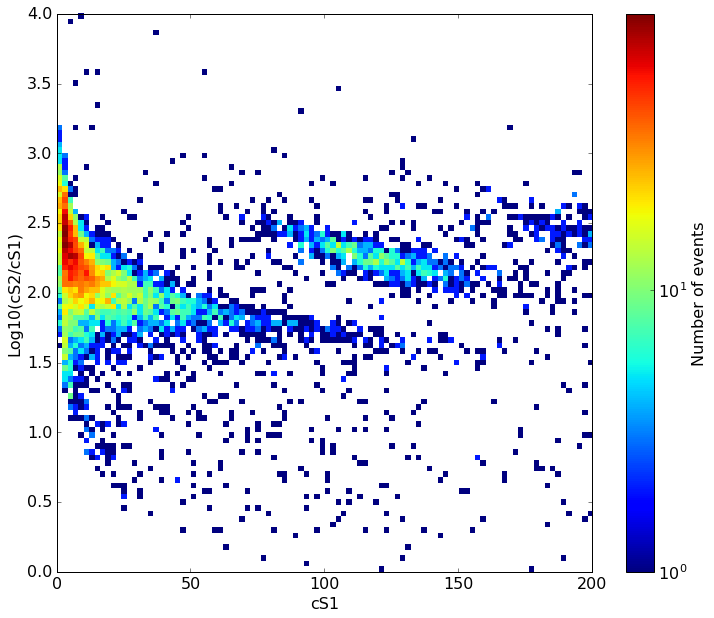

In [9]:
# Require a proper S1
data = data[data['cs1'] > 0]

# Make our standard s2/s1 histogram
plt.hist2d(data['cs1'], np.log10(data['cs2']/data['cs1']),
           bins=100, range=((0, 200), (0, 4)), norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Number of events')
plt.xlabel('cS1')
plt.ylabel('Log10(cS2/cS1)')
plt.show()

## Extracting your own data

Naturally, this basic data is rarely enough to do your work! Fortunately, extracting your own data is easy. You write a small TreeMaker class defining just one function: `extract_data`. This takes an `event` (pax/ROOT object as above) and returns a dictionary with the data you want to save for that event. 

(It's ok if the dictionary is not the same for every event, missing values will become NaNs).

For example, suppose your are interested in the widths of the main S1 and S2. You can set up your TreeMaker like so:

In [17]:
class PeakWidthInfo(hax.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.hit_time_std']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(s1_hit_time_std=s1.hit_time_std,
                    s2_hit_time_std=s2.hit_time_std)

Then you can read in data like this:

In [18]:
data = hax.load_minitrees('xe100_120402_2000', [PeakWidthInfo, 'Basics'])
data.head(5)

Found minitree at ./xe100_120402_2000_PeakWidthInfo.root
Minitreefile ./xe100_120402_2000_PeakWidthInfo.root is outdated (version 0.0.0, treemaker is version 0.0.1), will be recreated
Created minitree PeakWidthInfo for dataset xe100_120402_2000
Found minitree at ./xe100_120402_2000_Basics.root


,index,s1_hit_time_std,s2_hit_time_std,index,cs1,cs2,drift_time,event_number,event_time,largest_coincidence,...,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,22.333456,503.716614,0,494.062372,199043.333455,59534.808594,0,606771456,0,...,767.343811,0,0.000000,426.721161,0.208081,174377.593750,0.420520,4.900376,-3.659775,10.299521
1,1,19.813513,377.789001,1,122.873935,15259.199759,78566.101562,1,638229504,0,...,24.868357,0,0.000000,119.176933,0.218284,12814.677734,0.522556,0.062030,-1.922932,13.591935
2,2,NaN,NaN,2,NaN,NaN,NaN,2,654552576,0,...,7.597475,0,487.042175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,25.493958,408.579224,3,349.347776,2061.357109,113081.453125,3,665550592,0,...,1240.369873,0,0.000000,409.730682,0.157665,1603.313599,0.570126,-5.148496,4.652256,19.563091
4,4,NaN,NaN,4,NaN,NaN,NaN,4,686497536,0,...,33.421093,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Notice s1_hit_time_std and s2_hit_time_std are now part of the dataframe. While you ran the above cell, a file `xe100_120402_2000_PeakWidthInfo.root` was created in the current directory. The next time you run the cell, the information is taken from this file (which is extremely fast) instead of rebuilt from scratch.

What if you change something in your TreeMaker? You can simply force load_minitrees to rebuild your tree:

In [23]:
data =hax.load_minitrees('xe100_120402_2000', PeakWidthInfo, force_reload=True)

Found minitree at ./xe100_120402_2000_PeakWidthInfo.root
Created minitree PeakWidthInfo for dataset xe100_120402_2000


A gentler approach is to simply increment the version number of your TreeMaker. load_minitrees will notice the minitrees are outdated and rebuild them. (try it!)